# Homework 2: Coding Part
Due: Mar 2, 2023 at 11:00 pm

Submit through Gradescope

# Before we begin
In NumPy, the name of the game is vectorization. Whenever you have matrices and vectors, try to find an expression for them in terms of matrix manipulations. Then you can implement it NumPy so that *all* values in an array are calulated in one go. Then afterward, you can use appropriate functions (we will use `np.mean` a lot for example) to reduce the arrays. **If you can, it is best to avoid for loops and python control flows.** If you scroll down to "Linear Classification with Steepest Descent", you will see an example worked out regarding how you can try to fully utilize matrix and vector operations. 

Why?

First, the reason NumPy exists is that it has optimized these operations in C++ and is orders of magnitude faster than Python for loops. Second, while you can get away with using python control statements now (you will get the right answer, so that is not a problem), you **will not** be able to use them with Tensorflow easily. So it is best to practice to try to construct matrix and vector operations now, to prepare for using Tensorflow soon. 

Just to be clear, we will not penalize anyone for not using vectorization if they have the right answer. It is highly recommended though!



# Import datasets and extract features (copy over from the last homework)
In these first blocks, we are going to setup the same machine learning problem of classifying images of handwritten digits. Please refer to your HW1 code to copy and paste elements over to complete these first blocks, to get the problem appropriately setup.

First, just like in HW1, we will load the MNIST image dataset, normalize it, and reshape it appropriately. Don't forget to add the bias term to your features.

In case anyone has issues in this section, please contact the TAs at the lab session.

(***2 POINTS*** for the whole section)

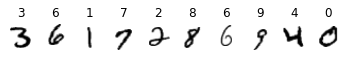

In [1]:
# Import datasets (just run this block)
%matplotlib inline

from sklearn import datasets
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from time import time

# might take a few minutes
digit, target = fetch_openml(
    "mnist_784", return_X_y=True, as_frame=False)
#normalize each digit image to have a max value of 1, and reshape into a 3D array, with all examples along the first dimension
digit = (digit/255.0).reshape(-1,28,28)
target = target.astype(int)
#plot several digits to example
for index, (image, label) in enumerate(list(zip(digit, target))[12:22]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('%i' % label)
plt.show()

Fantastic Visualization code: the following two functions are plotting tools that allow us to easily plot quantities of interest (same as we used in HW1). 

In [2]:
# just run this block
import matplotlib.lines as mlines
def newline(weight):
    # adapted from https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
    if len(weight) == 2:
        p1 = weight[0]
        p2 = weight[1]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = 0
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax)
            ymin = -p1/p2*(xmin)
        l = mlines.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
       
    elif len(weight) == 3:
        p1 = weight[0]
        p2 = weight[1]
        b = weight[2]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = -b/p1
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax) - b/p2
            ymin = -p1/p2*(xmin) - b/p2
        l = mlines.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
       
    return l

def visualize_model(features, labels, weights):
    plt.figure(figsize=(5,5))
    X_features_a = features[np.where(labels==-1)]
    X_features_b = features[np.where(labels==1)]
    plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.', label = "{}".format(number_a))
    plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.', label = "{}".format(number_b))
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max())
    newline(weights)
    plt.gca().legend(loc = 1)
    return None

Select the two digits that you would like to classify below!

600
600


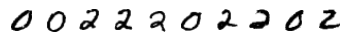

In [3]:
# in this block, you only need to modify number_a and number_b (if you wish to)
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(100)

number_a = 0 # TODO choose your digit
number_b = 2 # TODO choose your digit

digit_a_indexes = np.where(target==number_a)[0][:300] # to limit data
digit_b_indexes = np.where(target==number_b)[0][:300] # take only 300

targets = np.concatenate((target[digit_a_indexes], target[digit_b_indexes]))
print(targets.shape[0])
images = np.concatenate((digit[digit_a_indexes], digit[digit_b_indexes]))
print(images.shape[0])
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

Reduce the MNIST images into the two features of interest to create your "short" feature vectors to describe each digit. Please copy and paste from your HW1 code to complete this block! 

In [4]:
# please complete this function:
def compute_features(vector):
    image = vector.reshape(28, 28) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute the mean intensity of the image'''

        return np.mean(image) # TODO

    def compute_feature_b(image):
        '''compute_feature_b will compute symmetry score of the image'''
        diff_bw_halves = np.abs(image[:, :14] - image[:, 14:])
        symmetry_score = np.mean(diff_bw_halves)

        return symmetry_score # TODO
    
    return compute_feature_a(image), compute_feature_b(image)

(0.09664865946378552, 0.4796318527410964)

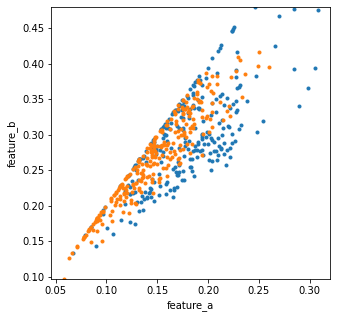

In [5]:
# Apply and plot your features (you can just run this block and inspect the output)
# This code applies the two feature computation functions to the training dataset, and then splits it into the two groups of interest

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')

plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

Don't forget to append a bias term to x - a vector of all ones.

Add them to both your training and testing data composed in the matrices X_train and X_test.

In [6]:
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_test =  np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

# add a bias term to the features

## Create array of ones for train data
ones = np.ones((X_features.shape[0], 1))
## Append the bias term
X_features_updated = np.concatenate((X_features, ones), axis=1)

## Create array of ones for test data
ones_test = np.ones((X_features_test.shape[0], 1))
## Append the bias term
X_features_test_updated = np.concatenate((X_features_test, ones_test), axis=1)

# convert training and testing labels to -1 and 1
## labels for train data
pseudo_y_train = np.copy(y_train)
pseudo_y_train[y_train == number_a] = -1
pseudo_y_train[y_train == number_b] = 1
## labels for test data
pseudo_y_test = np.copy(y_test)
pseudo_y_test[y_test == number_a] = -1
pseudo_y_test[y_test == number_b] = 1

*Now* we can have some fun.

# Linear Classification with Finite Differences

Rather than use pseudo inverse (analytically solving your optimization equation), we can use gradient descent methods to solve our optimization problem. In gradient descent, we see how the loss function changes when we change the weights and move 'downhill' to find the optimal weight for our model.

How do we know where is downhill? We take the gradient of the loss function with respect the to current weight vector. That gives the direction of the change. We then move opposite to that direction ('downhill'). We can numerically calculate this gradient. Recall that a derivative of a continuous function at some point $x$ is given as: $$ \lim_{δ\to 0} \frac{f(x+δ) - f(x-\delta)}{2δ}$$

We can make use of this. Note that this expression is slightly different than the definition of a discrete derivative that we used in class - it is a "center difference" derivative, as opposed to a forward or reverse difference.

To optimize the weights using finite differences to compute their gradient, start by initializing your weights parameter `w` to some random numbers. Move `w` some small `delta` amount in the each direction, and then compute the change in your loss function as a result of that small movement. Calculate the discrete gradient (i.e., the equation above applied to each weight term in the vector). Then update `w` by taking a small step in that gradient direction. You can execute this in a for loop for a set number of iterations, or until the gradient reaches some threshold value of not changing very much.

This method of perturbing the parameters slightly and taking the difference to calculate the gradient is called the method of Finite Differences, as covered in class with the examples that we worked through.

1. First use the above finite differences method to iteratively compute an optimal value for the vector `w`, using your training data and labels to evaluate the loss function in an effort to continually decrease it until some reasonable "stopping" criterion that is up to you to define.

2. We'll evaluate the training and test error at every $n$ steps

3. We'll plot the optimal weights (i.e., the optimal decision boundary) every $n$ steps

So, first, implement the loss function. For linear classification, it is the mean squared error. 

In [7]:
# 4 POINTS for correct implementation
def loss(features, labels, weights):
    ## Calculate the predictions
    predictions = np.dot(features, weights)
    ## Calculate the MSE loss
    mse = (np.sum((predictions - labels) ** 2)) / len(labels)

    return mse

### Now iteratively solve for your weights `w`, which includes the bias term. Please follow the pseudo-code below, which includes two key variables. First, `delta`, which is the finite difference amount used to compute the gradient at any given iteration step, and the second is `step_size`, which defines how large a "step" you will take to update w once the finite difference gradient is estimated.

In [8]:
def accuracy_metrics(features, weights, label):

    # Calculate predicted labels
    predicted_labels = np.dot(features, weights)

    # Assign classes based on threshold
    predicted_labels[predicted_labels > 0] = 1
    predicted_labels[predicted_labels < 0] = -1

    # Calculate accuracy
    correct_preds = [pred==actual for pred, actual in zip(predicted_labels, label)]
    accuracy = sum(correct_preds)/len(correct_preds) * 100
    
    return accuracy # Return the % accuracy

Train Accuracy: 50.93%
Train Accuracy: 40.56%
Train Accuracy: 42.41%
Train Accuracy: 52.96%
Train Accuracy: 54.44%
Train Accuracy: 55.37%
Train Accuracy: 58.15%
Train Accuracy: 59.07%
Train Accuracy: 60.19%
Train Accuracy: 60.93%
Final Train Accuracy: 61.48%


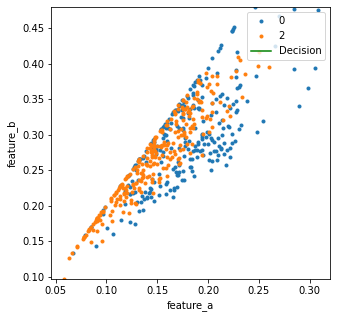

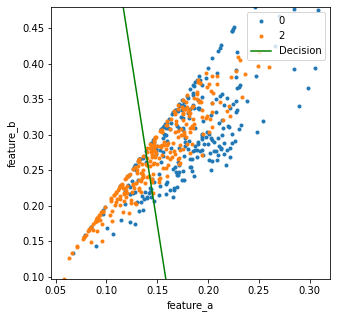

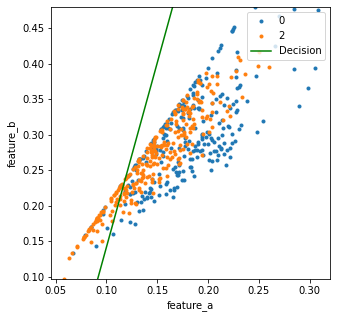

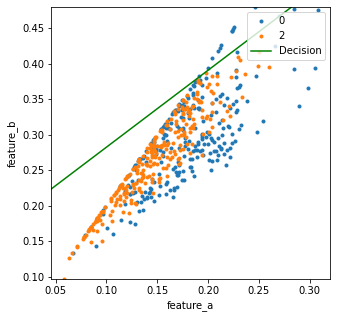

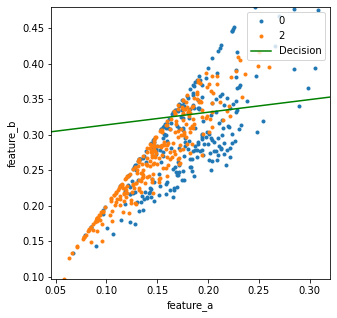

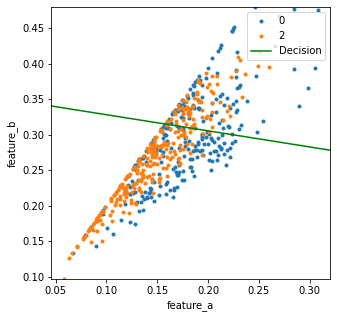

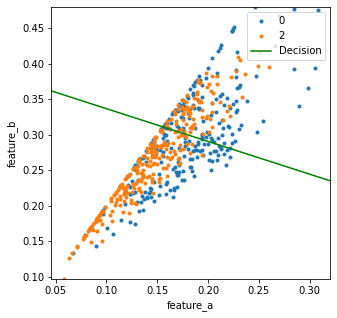

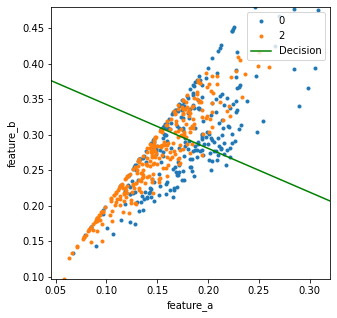

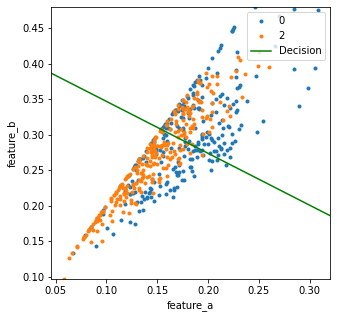

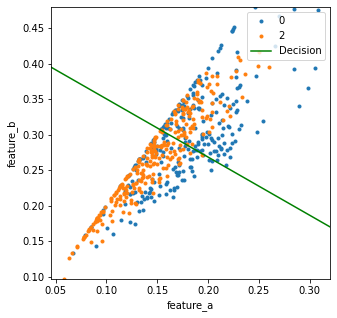

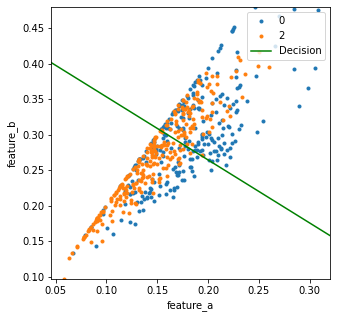

In [9]:
# 8 POINTS for correct implementation
w = np.random.rand(3) # init weights to some random value.
num_iterations = 200 # set this to the number of iterations
delta = 1e-2 # This may need to be adjusted
step_size = 2e-1 # This may also need to be adjusted
start_t = time()

for i in range(num_iterations):
    # move w0 some delta and calculate derivative in w0 direction
    weights_delta = w.copy()
    weights_delta[0] = weights_delta[0] + delta
    dl_w0_dw0 = (loss(X_features_updated, pseudo_y_train, weights_delta) - loss(X_features_updated, pseudo_y_train, w))/delta

    # move w1 some delta and calculate derivative in w1 direction
    weights_delta = w.copy()
    weights_delta[1] = weights_delta[1] + delta
    dl_w1_dw1 = (loss(X_features_updated, pseudo_y_train, weights_delta) - loss(X_features_updated, pseudo_y_train, w))/delta

    # move w2 some delta and calculate derivative in w2 direction
    weights_delta = w.copy()
    weights_delta[2] = weights_delta[2] + delta
    dl_w2_dw2 = (loss(X_features_updated, pseudo_y_train, weights_delta) - loss(X_features_updated, pseudo_y_train, w))/delta

    # these three numbers together form the gradient of loss at w
    # update w by taking some step_size in the direction of the gradient going down
    w[0] = w[0] - dl_w0_dw0 * step_size
    w[1] = w[1] - dl_w1_dw1 * step_size
    w[2] = w[2] - dl_w2_dw2 * step_size

    # plot the decision boundary and report accuracies every 20 iterations
    if i % 20 == 0:
        accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
        print(f"Train Accuracy: {accuracy_train:.2f}%")
        visualize_model(X_features_updated, pseudo_y_train, w)


end_t = time()

# print final accuracies and plot the decision boundary
final_accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
print(f"Final Train Accuracy: {final_accuracy_train:.2f}%")
visualize_model(X_features_updated, pseudo_y_train, w)


In [10]:
print("average time per iteration: {} seconds".format((end_t-start_t)/num_iterations))

average time per iteration: 0.0019206881523132324 seconds


# Logistic Classification with Finite Differences

Now, let's consider the same problem with a different loss function. From Problem 2 in the written part of this homework, we know that the loss function for a logistic model is:

$$L = \frac{1}{N}\sum_{i=1}^n ln(1 + e^{-y^{(i)}W^{T}x^{(i)}})$$

Use the finite differences method from above to find the optimal `w` for this loss function.

1. Solve for `w`
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps


In [11]:
# 6 POINTS for correct implementation
def logistic_loss(features, labels, weights):
    predictions = np.dot(features, weights)
    log_loss = (np.sum(np.log(1 + np.exp(-1 * predictions * labels)))) / len(labels)
    
    return log_loss

Train Accuracy: 50.93%
Train Accuracy: 44.07%
Train Accuracy: 50.93%
Train Accuracy: 53.70%
Train Accuracy: 54.26%
Train Accuracy: 53.89%
Train Accuracy: 54.44%
Train Accuracy: 56.11%
Train Accuracy: 57.41%
Train Accuracy: 57.59%
Final Train Accuracy: 58.70%


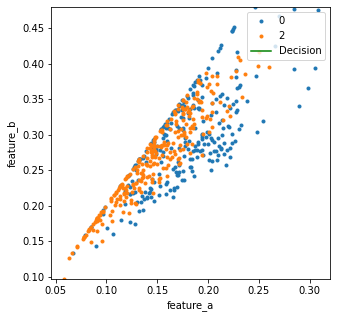

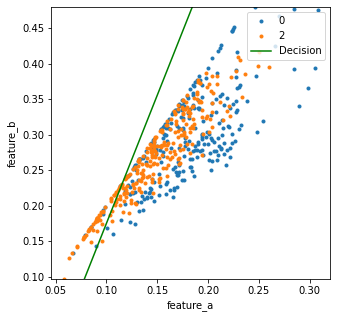

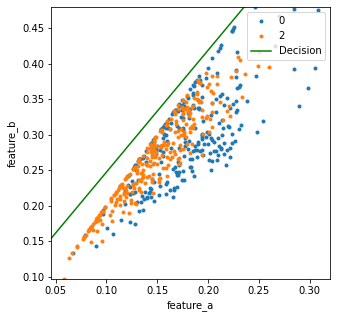

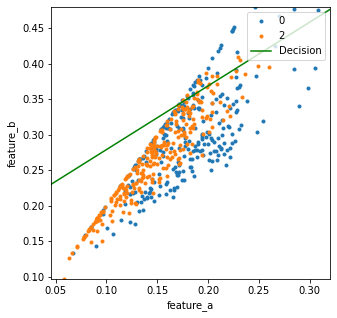

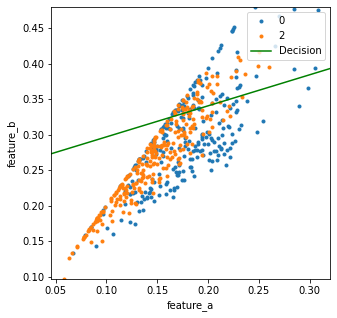

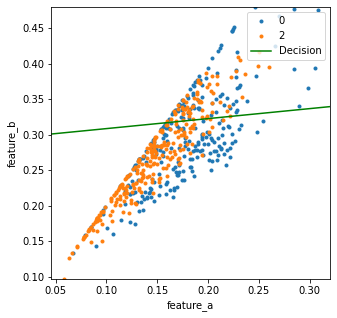

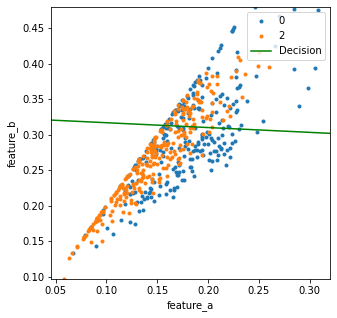

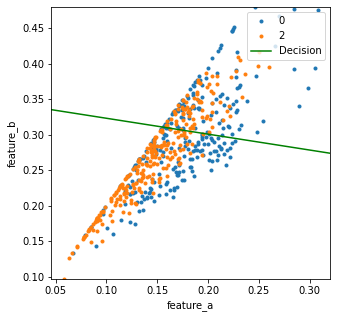

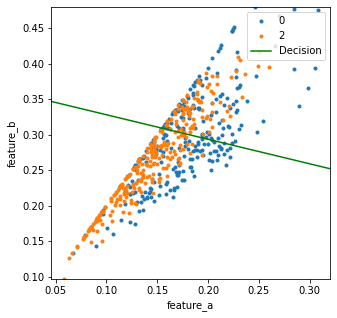

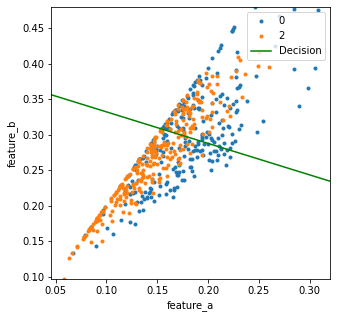

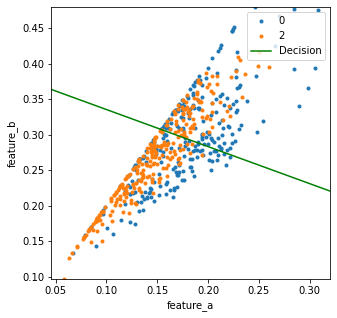

In [12]:
# 6 POINTS for correct implementation
w = np.random.rand(3) # init weights to some random value.
num_iterations = 200 # set this to the number of iterations
delta = 1e-2 # This may need to be adjusted
step_size = 1.1 # This may also need to be adjusted
# you might need step_size > 1 as we are taking a mean in this loss
start_t = time()

for i in range(num_iterations):
    
    # move w0 some delta and calculate derivative in w0 direction
    weights_delta = w.copy()
    weights_delta[0] = weights_delta[0] + delta
    dl_w0_dw0 = (logistic_loss(X_features_updated, pseudo_y_train, weights_delta) - logistic_loss(X_features_updated, pseudo_y_train, w))/delta
    
    # move w1 some delta and calculate derivative in w1 direction
    weights_delta = w.copy()
    weights_delta[1] = weights_delta[1] + delta
    dl_w1_dw1 = (logistic_loss(X_features_updated, pseudo_y_train, weights_delta) - logistic_loss(X_features_updated, pseudo_y_train, w))/delta
    
    # move w2 some delta and calculate derivative in w2 direction
    weights_delta = w.copy()
    weights_delta[2] = weights_delta[2] + delta
    dl_w2_dw2 = (logistic_loss(X_features_updated, pseudo_y_train, weights_delta) - logistic_loss(X_features_updated, pseudo_y_train, w))/delta
    
    # these three numbers together form the gradient of loss at w
    # update w by taking some step_size in the direction of the gradient going down
    w[0] = w[0] - dl_w0_dw0 * step_size
    w[1] = w[1] - dl_w1_dw1 * step_size
    w[2] = w[2] - dl_w2_dw2 * step_size

    # plot the decision boundary and report accuracies every 20 iterations
    if i % 20 == 0:
        accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
        print(f"Train Accuracy: {accuracy_train:.2f}%")
        visualize_model(X_features_updated, pseudo_y_train, w)

end_t = time()
# print final accuracies and plot the decision boundary
final_accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
print(f"Final Train Accuracy: {final_accuracy_train:.2f}%")
visualize_model(X_features_updated, pseudo_y_train, w)


In [13]:
print("average time per iteration: {} seconds".format((end_t-start_t)/num_iterations))

average time per iteration: 0.0018869328498840332 seconds


# Linear Classification with Steepest Descent

How do we make the optimization process go faster, and perhaps provide us with a more accurate result that we can easily track? 

Right now, we numerically estimate the gradient by perturbing weight values and taking the difference in losses. What that means is that we need two forward passes for every model parameter (so total of 6 passes) to make one weight update. Imagine doing this for a neural network that has millions of parameters. We will need to perturb every one of those values, find the difference in the loss values to estimate gradient, then update the weights (and repeat). This will be way too slow. Instead, we can actually just find a closed-form expression for the gradient analytically, and use that at each step directly, instead of estimating the gradient numerically. We'd expect this process to work much faster.

So with that in mind, let's first find the gradient of the linear loss function analytically and code it up. Please refer to the derivation below, also in HW1, to establish what this gradient function is for the linear classification with mean-squared error loss case. Iniitialize your weights parameter `w` to some random numbers. Using your function, find gradient of the loss the function for the current value of the parameter `w` and then update `w` by taking a small step in direction of the steepest gradient. You can execute this in a for loop for a set number of iterations, or until the gradient reaches some threshold value of not changing very much.

1. Solve for `w`
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps

## Define the gradient

**The following example has been worked out for you.**

The loss $L$ we would like to minimize for each $i$ row in our matrix is.

$$L  = \frac{1}{2}\Sigma (y^{(i)} - W^{T}x^{(i)})^{2}$$

where

$$x^{(i)} = 
\begin{bmatrix}
    feature_a \\
    feature_b \\
\end{bmatrix}$$

$$W = 
\begin{bmatrix}
    w_1 \\
    w_2 \\
\end{bmatrix}$$

We need to find the gradient of this loss. Let us vectorize the loss. It basically converts the individual operations into a matrix operation, such that we perform the operation on all datapoints at once.

In matrix form we convert $x^{(i)}$ into $X$ which is the number of examples we have, in our case is MNIST digit features extracted.

$$X = 
\begin{bmatrix}
    feature_{a1} & feature_{b1} \\
    feature_{a2} & feature_{b2} \\
    ... & ... \\
    feature_{ai} & feature_{bi} \\
\end{bmatrix}$$

and the labels become a vector (in this case a vector of the 'pseudo' labels we have 1, and -1)

$$Y = 
\begin{bmatrix}
    label_{1} \\
    label_{2} \\
    ... \\
    label_{i} \\
\end{bmatrix}$$

Then,

$$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Analytically, we can find that $$ \frac{d}{dW}L =  - X^{T}Y + X^{T}XW  $$

In [14]:
def linear_gradient(features, labels, weights):
  # finds the gradient of the loss function wrt the weight vector
  
  ## First term of gradient eq
  first_term = -features.T@labels ## Matrix Product
  
  ## Second term of gradient eq
  second_term = features.T@features@weights
  
  return first_term + second_term

### Now iteratively solve for your weights `w`, which includes the bias term.

Train Accuracy: 45.74%
Train Accuracy: 41.67%
Train Accuracy: 49.44%
Train Accuracy: 59.63%
Train Accuracy: 61.30%
Train Accuracy: 61.48%
Train Accuracy: 61.48%
Train Accuracy: 61.48%
Train Accuracy: 61.85%
Train Accuracy: 62.04%
Final Train Accuracy: 62.22%


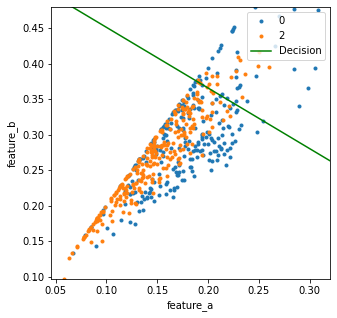

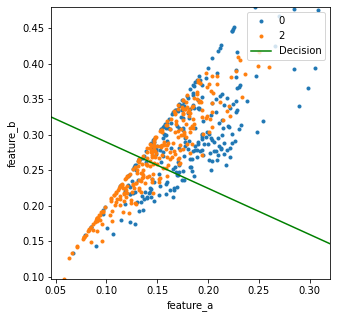

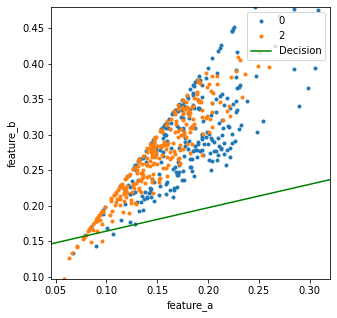

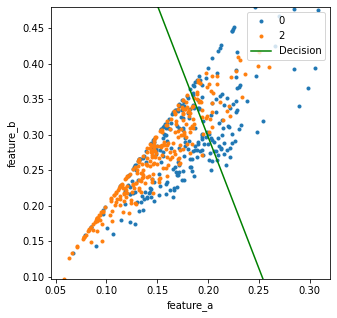

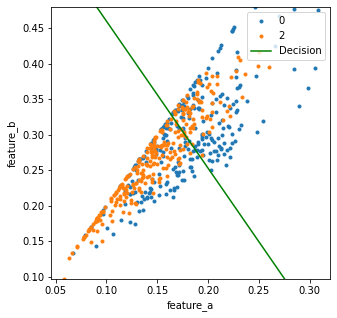

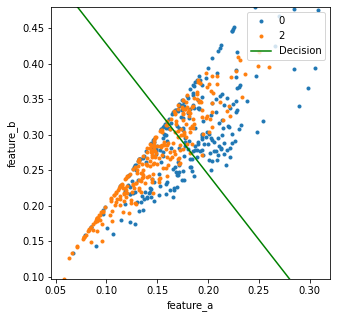

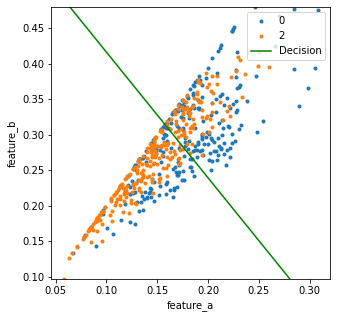

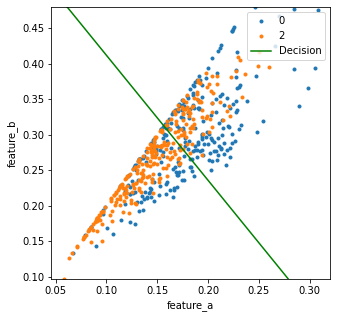

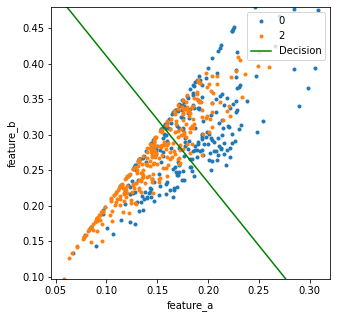

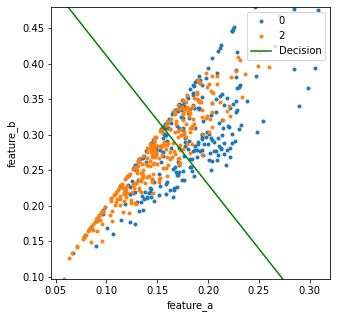

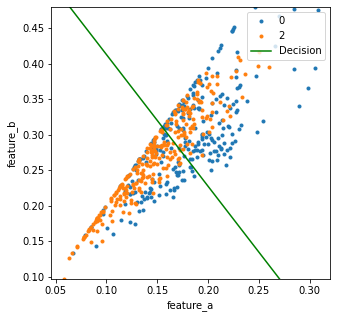

In [15]:
# 10 POINTS for correct implementation
w = np.random.rand(3) # init weights to some random value.
num_iterations = 200 # set this to the number of iterations
step_size = 2e-3 # This may also need to be adjusted
start_t = time()

for i in range(num_iterations):
    # calculate the gradient at the current weight vector
    grad = linear_gradient(X_features_updated, pseudo_y_train, w)

    # update w some step_size in the direction of steepest descent
    w = w - grad * step_size

    # make plots every 20 iters
    if i % 20 == 0:
        accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
        print(f"Train Accuracy: {accuracy_train:.2f}%")
        visualize_model(X_features_updated, pseudo_y_train, w)
    
end_t = time()
# print final accuracies and plot the decision boundary
final_accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
print(f"Final Train Accuracy: {final_accuracy_train:.2f}%")
visualize_model(X_features_updated, pseudo_y_train, w)

In [16]:
print("average time per iteration: {} seconds".format((end_t-start_t)/num_iterations))

average time per iteration: 0.0011242270469665528 seconds


# Logistic Classification with Steepest Descent

Now we repeat the same process with the **Logistic Loss function** written above (under Logistic Classification with Finite Differences). You have (hopefully) calculated an equation for the gradient of this Logistic Loss function in Problem 2 of the written part of this HW2. Please implement it now as a Python function.

Iniitialize your weights parameter `w` to some random numbers. Using your function, find gradient of the loss the function for the current value of the parameter `w` and then update `w` by taking a small step in direction of the steepest gradient. You can execute this in a for loop for a set number of iterations, or until the gradient reaches some threshold value of not changing very much.

1. Solve for `w`
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps

## Define the gradient
Logistic gradient is given as:
$$ \frac{d}{dW}L = {-}\Sigma (y_{i} - \sigma (W^{T}x_{i}))x_{i}$$

In [17]:
# 8 POINTS for correct implementation
def sigmoid(z):
  """
  Calculates and returns the sigmoid of the argument
  """
  return 1./(1. + np.exp(-z))

def logistic_gradient(features, labels, weights):
    return -1 * np.matmul(labels - sigmoid(np.matmul(features, weights)), features)

### Now iteratively solve for your weights `w`, which includes the bias term.

Train Accuracy: 49.07%
Train Accuracy: 49.07%
Train Accuracy: 49.26%
Train Accuracy: 49.44%
Train Accuracy: 49.63%
Train Accuracy: 49.81%
Train Accuracy: 49.81%
Train Accuracy: 49.81%
Train Accuracy: 49.81%
Train Accuracy: 49.81%
Final Train Accuracy: 49.81%


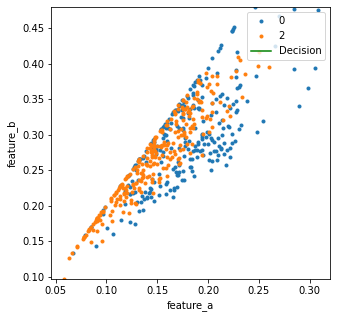

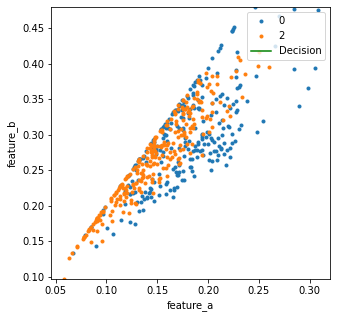

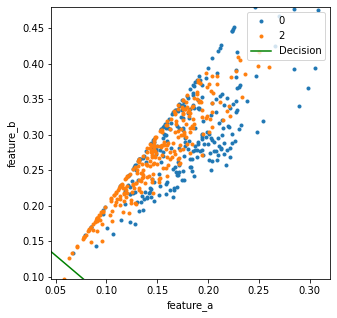

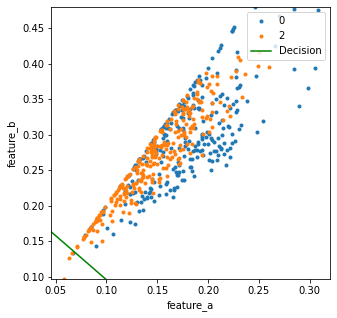

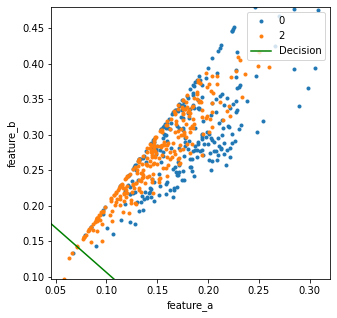

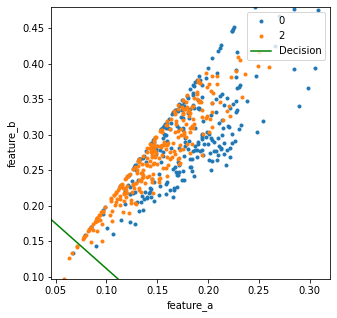

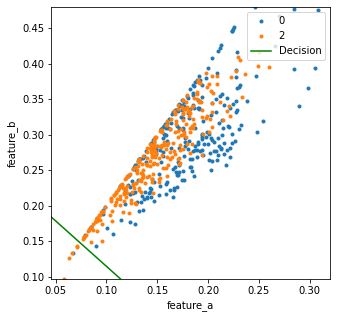

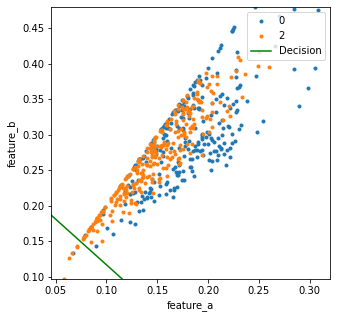

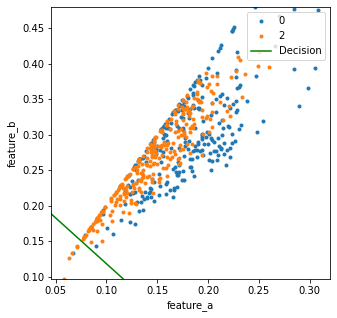

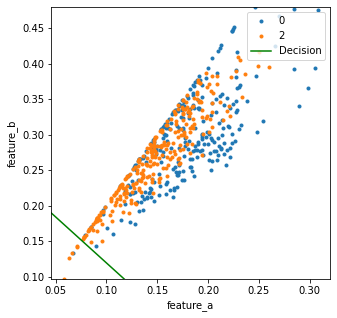

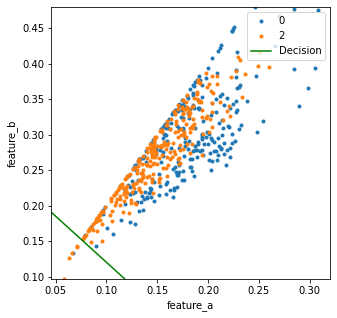

In [18]:
# 4 POINTS for correct implementation
w = np.random.rand(3) # init weights to some random value.
num_iterations = 200 # set this to the number of iterations
step_size = 1e-1 # This may also need to be adjusted
start_t = time()

for i in range(num_iterations):

    # calculate the gradient at the current weight vector
    grad = logistic_gradient(X_features_updated, pseudo_y_train, w)

    # update w some step_size in the direction of steepest descent
    w = w - grad * step_size

    # make plots every 20 iters
    if i % 20 == 0:
        accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
        print(f"Train Accuracy: {accuracy_train:.2f}%")
        visualize_model(X_features_updated, pseudo_y_train, w)

end_t = time()

# print final accuracies and plot the decision boundary
final_accuracy_train = accuracy_metrics(X_features_updated, w, pseudo_y_train)
print(f"Final Train Accuracy: {final_accuracy_train:.2f}%")
visualize_model(X_features_updated, pseudo_y_train, w)


In [19]:
print("average time per iteration: {} seconds".format((end_t-start_t)/num_iterations))

average time per iteration: 0.001236870288848877 seconds


Was Steepest Descent a faster approach? Since visualization takes a long time, commenting it out from the loop will improve your estimate for time taken. Also if you use the `%timeit` magic (refer to Lab Notebook 3 for example use or you can look it up), you will get a better estimate. (2 ***POINTS*** for a short analysis)

\<Your Answer here>

The following table displays the the time taken with visualization commented out:

|          Method            |        Time Taken    |
| -------------------------- | ---------------------|
| LinearFinite Differences   | 0.000734705924987793 |
| LogisticFinite Differences | 0.001384425163269043 |
| LinearSteepest Descent     | 0.000162711143493652 |
| LogisticSteepest Descent   | 0.000155516862869262 |

Based on the table above, the steepest descent was a faster approach than finite differences for both cases Linear and Logistic regression.